In [38]:
from src.simulation import ProteinSinthesisProcess, save_data

RESULTS_PATH = 'data/human_genoma_results.pkl'
SIM_TIME = 30

In [39]:
protein_synthesis_process = ProteinSinthesisProcess(data='human_genoma', verbose=True)
protein_synthesis_process.run(simulation_time=SIM_TIME) # run the simulation
save_data(protein_synthesis_process.dna_sequences_df, RESULTS_PATH, verbose=False)

DNA sequences loaded
Eucaryotes cell initialized
Simulation environment initialized 	
Simulation started: 	
Protein synthesized
Protein synthesized
Protein synthesized
Protein not synthesized


Results:

In [40]:
results_df = protein_synthesis_process.dna_sequences_df

In [41]:
print('Total number of dna sequences processed:', results_df[results_df['protein_synthesized'].notnull()].shape[0])
print('Total number of proteins synthesized:', results_df['protein_synthesized'].sum())
print('Number of true positives: ', results_df['protein_synthesized'].sum()-results_df[
    results_df['peptides_cardinality']==0]['peptides_cardinality'].size)
print('Number of false positives: ', results_df[results_df['peptides_cardinality']==0]['peptides_cardinality'].size)

Total number of dna sequences processed: 17
Total number of proteins synthesized: 5
Number of true positives:  3
Number of false positives:  2


In [47]:
results_df[results_df['peptides_cardinality']>0][
    ['polypeptides_chain_synthetized', 'polypeptides_chain_extended','peptides_cardinality']]

,polypeptides_chain_synthetized,polypeptides_chain_extended,peptides_cardinality
38477,H2N-SY-COOH,H2N-Ser-Tyr-COOH,2
38477,H2N-SY-COOH,H2N-Ser-Tyr-COOH,2
53080,H2N-YYICIQTPTGKRVEY-COOH,H2N-Tyr-Tyr-Ile-Cys-Ile-Gln-Thr-Pro-Thr-Gly-Ly...,15


Try to translate sequence false positive using BioPython

In [48]:
results_df[results_df['peptides_cardinality']==0][['sequence']]

,sequence
44471,GGGCCGCGAGAGGCGCCGGGATCGCGGGCGCCGGCTGAGCCAGCGG...
44471,TCTCCCGCGCGTCGCCGAAAGCGGCTCTGACCCAGCGGAAGTAATT...


In [49]:
from Bio.Seq import Seq
import random
from src.nucleotides import NucleotidesSymbolsAllocations

In [53]:
PROMOTERS = ['TATAAAA', 'TATAAAT', 'TATATAA', 'TATATAT']

def find_promoter(dna_sequence):
    # find promoter sequence
    positions_list = [dna_sequence.find(promoter) for promoter in PROMOTERS]

    if not any([pos > 0 for pos in positions_list]):
        #raise ValueError('No promoter found')
        return None
    else:
        promoter_posotion = min([pos for pos in positions_list if pos > 0])

    promoter_string = PROMOTERS[positions_list.index(promoter_posotion)]
    len_promoter = len(promoter_string)

    return dna_sequence[promoter_posotion+len_promoter:]

In [65]:
for dna_sequence in results_df[results_df['peptides_cardinality']==0]['sequence']:
    dna_sequence = ''.join([random.choice(NucleotidesSymbolsAllocations[n]) for n in dna_sequence])
    dna_sequence = find_promoter(dna_sequence)

    dna_sequence = Seq(dna_sequence)
    mRNA_sequence = dna_sequence.transcribe()
    mRNA_sequence = mRNA_sequence[:-(len(mRNA_sequence)%3)]
    print(mRNA_sequence)
    protein_sequence = mRNA_sequence.translate()

    if "*" in protein_sequence:
        # If there's a stop codon, truncate the protein sequence at the stop codon
        protein_sequence = protein_sequence[:protein_sequence.index("*")]

    print(protein_sequence)
    print('\t')

UACAGAGUUAUACAUACUACUUUGUAAGAUAACUUUUCUUUUCAAAACUGAAGUCAAUGUGAUAGAAUGGUGAGCAUUAUUUUGGAAGGCCAGACUAGGAGGAGGUGGGAGGAAGAAGUCAGACUCAGCCUGUGAACAGACGCUAACCUUGGCAGAAGCCAAAACAGUCAGACAGUGUUGUCUAAAAAUGAUCAUUCAAGAAGAGCGAAACAGCAAGGUGAUUUGUGAAAGAGAUUUAUUAGAAAAUGAAACACAUUUAUACCUCUGUUCAAUAAAAAUCUGCUUUUCGUC
YRVIHTTL
	
AGUUCAUUGCAAAGCAGAUUAUCUUGUUUUUUUGCAUAGCAAUCAAAGUUGAAAUUUGUUUGCUACAUCAACAAAUUAAGGACAUUUUCACAAACUGAGAAAUAAACAAAUAUGCCAAUUCGUAGGUGGUUUUGCCUUAUCCUUUGAAUGUGACUUAAAAUCAGCAAUGAUGAUAUAGUAAAUACUGAAAUUUAGGUGUAAAUCAAUACGUUCUACAGGGAAAUAAUGAGGCUAAGUAUUUUUAUGUUUUUAGUGGUUUUUUAGAAACCUAAUCUUAUAGCCGCCAUUAGCAUUACUAGAGUUAUGCAAAUAAUUGCAUUAUAAACAUGUUUAUAACUUAGCCAAAACAUUGAUUUUUAUAACUCUCCAAGUAUGAGUUGAAAUUUCUUAUGUCUUUUGAUAAACUGCAGUAUUCUUUAAGUGUACUUUGUCCUUUUGUUUAUUGCUACAAUUUAAGAACUUUAUUUAAAAACAAUUUUGGAAGGUUACUAGGUACAGCUUUUGCAGAAGAAACUGAACUGUAGCCAGAUGGUCAGCAAGUAAACUACAUGACUUAGAGUUCUUGUGCAUUAUACAUUUUGGGUAAUUCAAAGUACUGUAUUUGCAUUGACUAUAAAGCGUCGUUUGCAAUAUUUAUUCUUCCUUCAUAGUCCCUUGUUGUGAUUAUACUUCCAGUUGUUUAAAUGUAUUUUAAAAG

See how many TATA box in each dna sequence:

In [77]:
PROMOTERS = ['TATAAAA', 'TATAAAT', 'TATATAA', 'TATATAT']
tata_box_cardinality = []

for dna_sequence in results_df['sequence'].unique():
    # count how many tata boxes are in the sequence
    dna_sequence = Seq(dna_sequence)
    tata_box_count = 0
    for promoter in PROMOTERS:
        tata_box_count += dna_sequence.count(promoter)
        
    tata_box_cardinality.append(tata_box_count)

In [79]:
max(tata_box_cardinality)

117

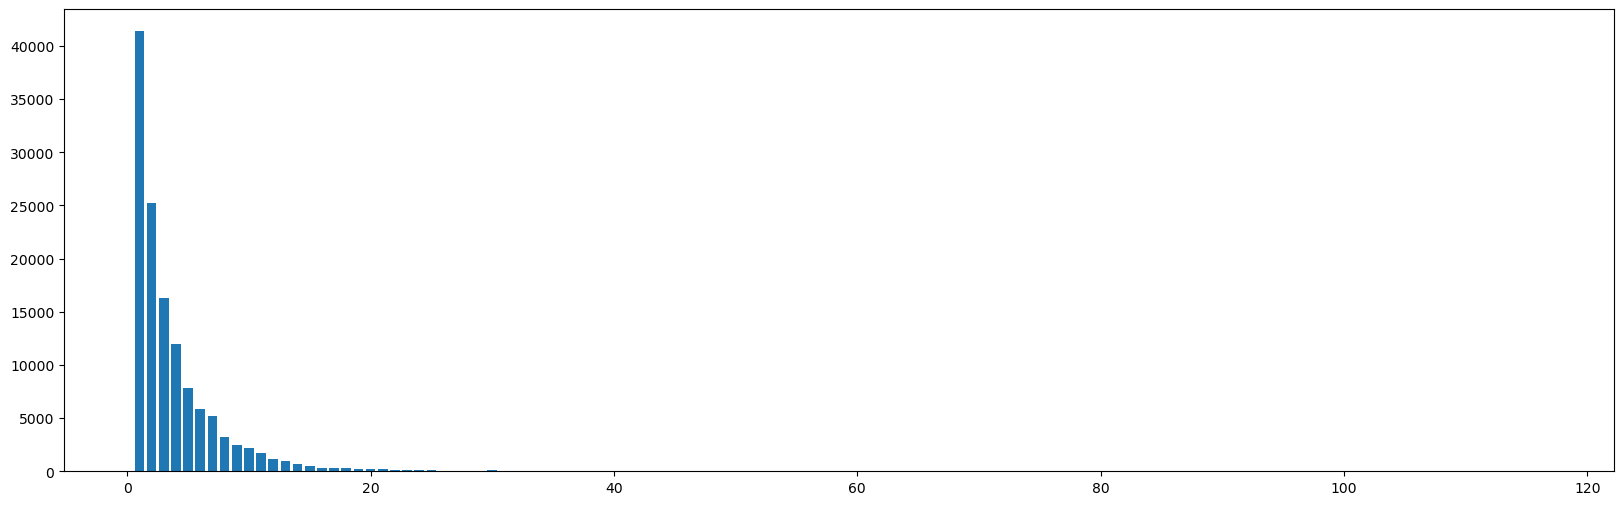

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,6))
plt.bar(range(1,117), [tata_box_cardinality.count(i) for i in range(1,117)]);

### New dataset

In [1]:
from HumanGenomeDataset.load_dataset import load_dataset

protein_coding_sequences_df = load_dataset('dna_protein_coding_sequences')
rna_sequences_df = load_dataset('rna_sequences') 
protein_sequences_df = load_dataset('protein_sequences')

In [2]:
protein_coding_sequences_df.head(2)

,ID,sequence,category
0,NM_001368254.1,GCTGAGCTGAGCTGGGGCGCAGCCGCCTGTCTGCACCGGCAGCACC...,NM
1,NM_001350977.1,TCCACAACTGAAACATCCACTTCTGAACACCATGTCCTACTACAGC...,NM


In [3]:
rna_sequences_df.head(2)

,ID,sequence
0,NR_168385.1,AGCAGGGCGTCCAGCGGAGAAGGCAGAGGAGGGGAGATGCGGGCTC...
1,NR_168384.1,AGCAGGGCGTCCAGCGGAGAAGGCAGAGGAGGGGAGATGCGGGCTC...


In [4]:
protein_sequences_df.head(2)

,ID,protein
0,NP_001355183.1,MLLMVVSMACVGLFLVQRAGPHMGGQDKPFLSAWPSAVVPRGGHVT...
1,NP_001337906.1,MSYYSHLSGGLGCGLAVAVTMGRTVAVAEYGRCRHGCHSSYSAR
